--------
# Bulut Sınıflandırması...
----

## 1.  Giriş..

Bu bölümde **CUMULO karşılaştırmalı veri kümesini** kullanacağız. Bulutların modellenmesi ve iklim sistemiyle etkileşimlerinin anlaşılması, gelecekteki iklim tahminlerinde belirsizliği azaltmak için kilit sorunlardan biridir. Bu belirsizliği azaltmanın önemli bir ilk adımı, bulut türlerini yüksek uzamsal ve zamansal çözünürlükte doğru bir şekilde sınıflandırmaktır.Bu iş akışında, bulutları sekiz Dünya Meteoroloji Örgütü (WMO) türünden birine sınıflandırmak için bir Makine Öğrenimi modeli   
eğiteceğiz. Bu iş akışı, küresel ölçekte hiperspektral uydu görüntüleri ve bir piksel alt kümesi için bulut etiketleri (yalnızca uydunun yolu boyunca) sağlayan bir veri kümesi olan CUMULO'yu kullanacağız..

## 2. Makine Öğrenmesi Algoritması..

Bu iş akışı içerisinde , ağaç tabanlı öğrenme algoritmaları topluluklarını kullanan bir gradyan artırma çerçevesi olan LightGBM'den yararlanır. Bu yaklaşımı, hesaplama açısından verimli olduğu ve yüksek doğruluklu modeller sağladığı için seçiyoruz.

Az sayıda etiket göz önüne alındığında, bir piksel düzeyinde bir model ve etiketli bölgedeki alt örnek verileri (karolar) eğitiriz. Daha doğrusu, bir dizi karar ağacı oluşturmak ve onların tahminlerini probleme uyacak şekilde birleştirmek için LightGBM çerçevesini kullanıyoruz. Bu, seçilen amaç fonksiyonunu (eğitim örneğindeki ortalama kayıp) en aza indirerek mevcut modelin yinelemeli olarak güncellenmesiyle yapılır. Her yinelemede, LightGBM karar ağaçlarını yaprak şeklinde büyütür: maksimum kayıp iyileştirmesi olan yaprağı seçer ve ona alt düğümler ekler, vb.

## 3. Veri..

Verisetimizde bulut katmanları bulunur. Bulut katmanı türleri aşağıdaki gibi sınıflandırılır:
* 0 - Cirrus
* 1 - Altostratus
* 2 - Altocumulus
* 3 - Stratus
* 4 - Stratocumulus
* 5 - Cumulus
* 6 - Nimbostratus
* 7 - Deep Convection

In [7]:
# 1. Kütüphanelerimizi Yükleyelim..
import netCDF4 as nc4
import numpy as np
from pathlib import Path
from tqdm import tqdm
import os
import sys
import glob
from nc_tile_extractor import extract_cloudy_labelled_tiles
import zipfile
import lightgbm as lgb
from loader import CumuloDataset
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings("ignore")

# 2. Yardımcı Fonksiyonumuz..
def read_nc(nc_file):
    
    file = nc4.Dataset(nc_file, 'r', format='NETCDF4')
    f_radiances = np.vstack([file.variables[name][:] for name in radiances])
    f_properties = np.vstack([file.variables[name][:] for name in properties])
    f_rois = file.variables[rois][:]
    f_labels = file.variables[labels][:]
    f_lats = file.variables[coordinates[0]][:]
    f_longs = file.variables[coordinates[1]][:]
    
    file.close()
    return f_radiances, f_properties, f_rois, f_labels, f_lats, f_longs

### Verilerin Hazırlanması..

Kullandığımız veri seti CUMULO'dır. CUMULO  veri kümesinin alt kümesi, CF kuralına göre NetCDF formatında 150 dosyadan oluşur. Alan başına, *her 5 dakikada bir ve 1 km'ye 1 km'lik bir uzamsal çözünürlükte bir NetCDF vardır. Bu NetCDF dosyalarının isimlendirilmesi şöyledir ; 

* **filename** = AYYYYDDD.HHMM.nc
    * **YYYY** = Yıl..
    * **DDD**  = Mutlak gün.. 
    * **HH**   = Günün saatleri..
    * **MM**   = Dakikalar..
    
Kullandığımız veri dosyaları 18 Ocak 2008 için geçerlidir. Bir dosya açıp içeriğini inceleyelim şimdi. NetCDF4 yapıcısıyla bir netCDF dosyası açabiliriz.  Her dosyanın 31 değişken içerdiğini görebilirsiniz.

In [8]:
# 3. Verimizi Yükleyelim.
nc_dir = "C:\\Users\\ernsb\\Desktop\\AI FOR EARTH\\AI Projeler\\bulutt\\month_1_day_18\\"
nc_files = glob.glob(nc_dir+"*.nc")
file = nc4.Dataset(nc_files[0], 'r', format='NETCDF4')

Kullandığımız veri tipi olan CUMULO, coğrafi referanslı noktalar başına farklı türde özellikler (kanallar) sağlar. Sağlanan bu özelliklerden biz şu özellikleri kullanıyoruz : 

* 13 calibrated radiances : 13 Kalibre edilmiş parlaklık.. Bu sayede giriş kanalları olarak bulut sınıflandırması için gereken fiziksel özelikleri yakalarız.


* Temel olarak mevcut etiketler.


* Hangi ızgara noktalarının analiz edileceğini seçmek için **cloud_mask** (yalnızca bulutlu olanlar) seçiyoruz.


* Fiziksel olarak doğrulamak için bulut özellikleri modelini seçiyoruz. Bu kanallar ham ışımalardan türetilir ve bir bulutun üst basıncı, sıcaklığı vb. gibi daha yüksek seviyeli özelliklerini sağlar.

*Şimdi bu yukarıdaki özelliklerden yola çıkalim ve ilgilendiğimiz değişkenleri alalım. İşte ilgilendiğimiz değişkenlerin listesi:*

In [9]:
# 4. İlgilendiğimiz Değişkenleri Aldık.

coordinates = ['latitude', 'longitude']
radiances = ['ev_250_aggr1km_refsb_1', 'ev_250_aggr1km_refsb_2', 
             'ev_1km_emissive_29', 'ev_1km_emissive_33', 
             'ev_1km_emissive_34', 'ev_1km_emissive_35', 
             'ev_1km_emissive_36', 'ev_1km_refsb_26', 
             'ev_1km_emissive_27', 'ev_1km_emissive_20', 
             'ev_1km_emissive_21', 'ev_1km_emissive_22', 
             'ev_1km_emissive_23']

properties = ['cloud_water_path', 'cloud_optical_thickness', 
              'cloud_effective_radius', 'cloud_phase_optical_properties', 
              'cloud_top_pressure', 'cloud_top_height', 
              'cloud_top_temperature', 'cloud_emissivity', 
              'surface_temperature']

rois = 'cloud_mask'
labels = 'cloud_layer_type'

Sonraki adımda , her dosyadan 3x3 piksel boyutunda pencereler çıkartma yapmaktır. Bu kutucukları, Makine Öğrenimi modelimizde girdi olarak kullanacağız. 3x3 piksel döşemeleri, bir görüntünün etiketlenmiş her pikseli etrafında örneklenir. Böylece karolar üst üste gelebilir. Her biri **.npy** biçiminde bir değişken içeren sıkıştırılmış bir dosya arşivi olan **.npz** biçiminde saklanacaktır. 

In [10]:
# 5.  Girdi Verilerini Ayarlayalim.. 

nc_dir = Path("C:\\Users\\ernsb\Desktop\\AI FOR EARTH\\AI Projeler\\bulutt\\month_1_day_18\\")

# make directory where tiles will be stored
save_dir = Path("C:\\Users\\ernsb\Desktop\\AI FOR EARTH\\AI Projeler\\bulutt\\")
save_dir.mkdir(parents=True, exist_ok=True)

# retrieve all files in netcdf format
nc_paths = nc_dir.glob("*.nc")

Şimdi her bir netCDF dosyasını gözden geçirelim ve aşağıdaki işlemleri gerçekleştirelim:

* read_nc() yardımcı işleviyle netCDF dosyasından gerekli değişkenleri çıkaralim. Bu işlev bir netCDF dosyası yükler ve gerekli parlaklıklar, özellikler, cloud_mask ve cloud_labels ile dört maskeli dizi döndürür.

* etiketli bir bulut alanından tüm döşemeleri ayıklayan extract_cloudy_labelled_tiles işlevini uygulayalim.

* kutucuk tabanlı parlaklıkları, özellikleri, cloud_mask, cloud_labels ve konumu sıkıştırılmamış .npz dosyası olarak kaydedelim.

In [11]:
# 6..

for filename in tqdm(nc_paths):
    
    # load swath variables and label masks
    f_radiances, f_properties, f_cloud_mask, f_labels, *_ = read_nc(filename)
    
    # labelled pixels have at least one non-zero value over the vertical axis
    f_label_mask = np.sum(~f_labels.mask, 3) > 0
    
    # for the purposes of this tutorial, we are going to extract only labelled tiles
    try:
        labelled_tiles, labelled_positions = extract_cloudy_labelled_tiles((f_radiances, f_properties, f_cloud_mask, f_labels), f_cloud_mask[0], f_label_mask[0])
        
        name = os.path.basename(filename).replace(".nc", ".npz")

        np.savez_compressed(save_dir / name, 
                            radiances=labelled_tiles[0].data, 
                            properties=labelled_tiles[1].data, 
                            cloud_mask=labelled_tiles[2].data, 
                            labels=labelled_tiles[3].data, 
                            location=labelled_positions)
    
    except:
        pass

159it [04:23,  1.66s/it]


### Verilerin Yüklenmesi..

Sonraki adım, ML bulut sınıflandırıcısını egitmek için verileri yüklemektir. CumuloDataset(), az önce çıkardığımız döşemeleri yükleyen bir kurucudur. Çağrıldığında, LightLBM modeli için girdi olarak kullandığımız parlaklık kanallarını ve çıktı olarak kullandığımız etiketleri döndürür. Burada bilmemiz gereken birkaç şey var, bir kutucuğun birden fazla etiketi olabileceğinden CumuloDataset() yalnızca en sık kullanılanı dönderir.

*Argüman olarak şunları verebiliriz :* 

* **root_dir:** Verilerin depolandığı dizin
* **ext:** okunacak verileri içeren dosyaların uzantısı/biçimi (bu örnekte npz)

In [12]:
# 7. Verilerin Yüklenmesi
dataset = CumuloDataset(root_dir="C:\\Users\\ernsb\Desktop\\AI FOR EARTH\\AI Projeler\\bulutt\\", ext="npz")

Daha sonra, LightGBM modelinin gerektirdiği şekilde tüm verileri bir kerede yüklemek ve vektörleştirmek istiyoruz. Sonuç, aşağıdaki vektörleştirilmiş verilerdir:

* X - Model için girdi olarak parlaklıklar
* y - model için çıktı olarak bulut etiketleri
* p - Sonuçları fiziksel düzeyde de değerlendirmek için daha sonra kullanılan fiziksel özellikler

In [13]:
# 8. Vektörleştirme İşlemleri.. 
xs, ys, props = [], [], []

for filename, radiances, properties, cloud_mask, labels in dataset:
    xs.append(radiances) # radiances
    ys.append(labels) # labels
    props.append(properties) # we load also the physical properties and use them later on for physical evaluation

shape = xs[0].shape
X = np.vstack(xs).reshape(-1, shape[1] * shape[2] * shape[3]) # vectorize tiles
y = np.hstack(ys)

shape = props[0].shape
p = np.vstack(props).reshape(-1, shape[1] * shape[2] * shape[3]) # vectorize tiles

# 9. Elde Ettiğimiz Verilerin Boyutlarına Bakalim..
print("Model İçin Girdi Parlaklıkların Sayısı..:", X.shape)
print("Model İçin Çıktı Olarak Bulut Etiketleri..:",y.shape)
print("Sonuçları Fiziksel Düzeyde de Değerlendirmek İçin Kullanılan Fiziksel Özellikler...:",p.shape)

Model İçin Girdi Parlaklıkların Sayısı..: (63945, 117)
Model İçin Çıktı Olarak Bulut Etiketleri..: (63945,)
Sonuçları Fiziksel Düzeyde de Değerlendirmek İçin Kullanılan Fiziksel Özellikler...: (63945, 81)


Şimdi, eğitim, doğrulama ve test için girdi ve çıktı değişkenlerini alt kümelere ayırabiliriz.

**training data:** Makine Öğrenimi modelini eğitmek için kullanılan gerçek örnektir.

**validation data:** Eğitim sırasında bir modeli değerlendirmek için kullanılır, ancak model bu verilerden öğrenmez.

**test data:** Nihai modelin bir değerlendirmesini sağlamak için kullanılır ve yalnızca bir model tamamen eğitildiğinde kullanılır.

Bu işlemler önemlidir. Önemli olmasının sebebi, model performansının doğru bir şekilde değerlendirilmesi ve modelin sadece eğitim verilerini ezberlememesi için bu tarz kümeleme işlemleri yaparız. 

In [14]:
# 10. Bölme İşlemini Yapiyoruz..
# we use 20% of data as test set
train_xs, test_xs, train_ys, test_ys = train_test_split(X, y, test_size=0.20, random_state=42)

# we use 10% of the remaining data for validation
train_xs, val_xs, train_ys, val_ys = train_test_split(train_xs, train_ys, test_size=0.10, random_state=42)

print(train_xs.shape, train_ys.shape, val_xs.shape, val_ys.shape, test_xs.shape, test_ys.shape)

(46040, 117) (46040,) (5116, 117) (5116,) (12789, 117) (12789,)


### Bir LightGBM Modeli Tanımlayacağız  ve Eğiteceğiz

Sonraki adım, lightGBM kitaplığını yüklemek ve eğitim ve doğrulama alt kümelerini bir **lightgbm.basic.Dataset'e** dönüştürmektir. Bu işlemleri yapmadan önce birazcık bu model hakkında konuşmak gerekli.

LightGBM, ağaç (RandomForest, DecisionTree) tabanlı öğrenme algoritmalarını kullanan bir gradyan artırma çerçevesidir. Aşağıdaki avantajları barındıran ve verimli olacak şekilde tasarlanmış bir algoritmadır. Hangi özelliklerden dolayı kullanılıyor dersek eğer : 

* Daha hızlı eğitim hızı ve daha yüksek verimlilik.
* Daha düşük bellek kullanımı.
* Daha iyi doğruluk.
* Paralel, dağıtılmış ve GPU öğrenimi desteği.
* Büyük ölçekli verileri işleme yeteneğine sahiptir.

*Şimdi aşağıda modelimizi oluşturalim..*

In [15]:
# 11. LightGBM Modeli Olusturuyoruz..
lgb_train = lgb.Dataset(train_xs, train_ys)
lgb_valid = lgb.Dataset(val_xs, val_ys)

Bu adım da , bir Makine Öğrenimi modelinin ince ayarının yapılabileceği bir dizi hiper parametre belirlemektir. LightGBM birkaç algoritma sunar ve hiperparametreler modelin performansını güçlü bir şekilde etkiler.

Aşağıda modeli eğitirken kullanacağımız parametreleri burada açıklayalim..

* **boosting_type:** Default değeri gbdt. Geleneksel Gradyan Artırma Karar Ağacı anlamına gelir. Alternatifleri için dökümana bakabiliriz.


* **objective:**  Kullandığımız değer burada **multiclass**. Bu parametre kullanılacak öğrenme görevini ve ilgili öğrenme hedefini veya özel bir hedef için işlevi belirtmemizi bekler. 


* **num_classes :** Kullandığımız değer burada 8. Belirlemek istediğimiz bulut sınıf sayısını ifade eder.


* **num_iterations :**  Burada kullandığımız değer 400. Bu değer maksimum yineleme sayısınu ifade eder. Burada her yinelemede sınıf başına yeni bir karar ağacı probleme uyarlanır.


* **num_leaves :**  Burada kullanılan değer 31. Bu parametre, Kullanılan ağaç algoritmasında ki bir ağacın maksimum yaprak sayısını ifade eder.


* **learning_rate :** Burada kullanılan değer 0.1. Bu oran, Öğrenme işlemini yaparken ki adım sayısını ifade eder.  


* **verbose :** Burada verdiğimiz değer 0. Bu değer, yalnızca  hataları ve uyarıları yazdırmak için ayarladığımız değer. Bu sayede  ayrıntı düzeyini 0 olarak ayarladık ki gereksiz detayları görmeyelim..

Sonraki adım, algoritmayı yukarıda tanımlanan hiperparametrelere dayalı olarak eğitim verisi alt kümesinde çalıştırmaktır. **lightGBM kitaplığındaki train()** işlevini kullanabilirsiniz bu işlem için. Bu algoritma , aşağıdaki değişkenleri alir.

* **params:** Tanımlanmış hiperparametreler
* **dataset:** Eğitim verisi alt kümesi
* **valid_sets:** Doğrulama verisi alt kümesi

Doğrulama veri kümesi, bu alt kümenin performansına dayalı olarak en iyi performans gösteren modeli seçmek için kullanılır. Gerçekten de, en iyi model mutlaka eğitim döngüsünün sonunda elde edilen model değildir, çünkü eğitim setini ezberlemeye başlamış olabilir ve bu da çıkarım/test sürecinde kötü bir performansa neden olabilir.

In [16]:
# 11. Kullanacağımız Parametreleri Tanımlayalim..
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_classes': 8,
    'num_iterations': 400,
    'num_leaves': 31,
    'learning_rate': 0.1,
    'verbose': 0,
}

# 12 GBM Train Edelim..
gbm = lgb.train(params, lgb_train, valid_sets=[lgb_valid])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's multi_logloss: 1.39531
[2]	valid_0's multi_logloss: 1.27845
[3]	valid_0's multi_logloss: 1.19207
[4]	valid_0's multi_logloss: 1.11918
[5]	valid_0's multi_logloss: 1.06073
[6]	valid_0's multi_logloss: 1.01149
[7]	valid_0's multi_logloss: 0.969147
[8]	valid_0's multi_logloss: 0.934612
[9]	valid_0's multi_logloss: 0.904023
[10]	valid_0's multi_logloss: 0.87687
[11]	valid_0's multi_logloss: 0.852764
[12]	valid_0's multi_logloss: 0.832791
[13]	valid_0's multi_logloss: 0.814842
[14]	valid_0's multi_logloss: 0.798338
[15]	valid_0's multi_logloss: 0.7826
[16]	valid_0's multi_logloss: 0.769882
[17]	valid_0's multi_logloss: 0.757787
[18]	valid_0's multi_logloss: 0.746473
[19]	valid_0's multi_logloss: 0.73692
[20]	valid_0's multi_logloss: 0.727597
[21]	valid_0's multi_logloss: 0.719662
[22]	valid_0's multi_logloss: 0.711

[207]	valid_0's multi_logloss: 0.501002
[208]	valid_0's multi_logloss: 0.500895
[209]	valid_0's multi_logloss: 0.50055
[210]	valid_0's multi_logloss: 0.500051
[211]	valid_0's multi_logloss: 0.499789
[212]	valid_0's multi_logloss: 0.499631
[213]	valid_0's multi_logloss: 0.49929
[214]	valid_0's multi_logloss: 0.499304
[215]	valid_0's multi_logloss: 0.499132
[216]	valid_0's multi_logloss: 0.499026
[217]	valid_0's multi_logloss: 0.498697
[218]	valid_0's multi_logloss: 0.49844
[219]	valid_0's multi_logloss: 0.498323
[220]	valid_0's multi_logloss: 0.498059
[221]	valid_0's multi_logloss: 0.497705
[222]	valid_0's multi_logloss: 0.497525
[223]	valid_0's multi_logloss: 0.497224
[224]	valid_0's multi_logloss: 0.497287
[225]	valid_0's multi_logloss: 0.497236
[226]	valid_0's multi_logloss: 0.496911
[227]	valid_0's multi_logloss: 0.496979
[228]	valid_0's multi_logloss: 0.496906
[229]	valid_0's multi_logloss: 0.496582
[230]	valid_0's multi_logloss: 0.496398
[231]	valid_0's multi_logloss: 0.496356
[23

### Eğitilmiş LightGBM Modeliyle Bulut Sınıflarını Tahmin Etme

Bu tarz işlemlerde en iyi sınıf tahminini yapmak için en yüksek performansa sahip modeli kullanmamız gerekir. Bu model de genel de dogrulama kaybının en düşük olduğu modeldir. En iyi model **gbm.best_iteration** ile tanımlanabilir.

Eğitim, doğrulama ve test verisi alt kümeleri hakkında tahminlerde bulunmak için en iyi modeli kullanmak isteriz genelde . Daha sonraki bir aşamada, ilgili veri alt kümelerini tahmin etmek için modelin performansını değerlendirebiliriz.

**"gbm.predict()"** işlevi, eğitilmiş **"lightGBM"** modeline ve sırasıyla eğitim, doğrulama ve test girdi verilerine dayalı olarak bulut türlerini tahmin etmemize olanak tanır.

In [19]:
# 13..

train_prob_pred = gbm.predict(train_xs, num_iteration = gbm.best_iteration)
val_prob_pred = gbm.predict(val_xs, num_iteration = gbm.best_iteration)
test_prob_pred = gbm.predict(test_xs, num_iteration = gbm.best_iteration)

# 14..

print("Train_prob_pred Boyutu..:",train_prob_pred.shape)
print("Val_prob_pred Boyutu..:",val_prob_pred.shape)
print("Test_prob_pred Boyutu..:",test_prob_pred.shape)

Train_prob_pred Boyutu..: (46040, 8)
Val_prob_pred Boyutu..: (5116, 8)
Test_prob_pred Boyutu..: (12789, 8)


Tahmin süreci, her giriş verisi  için sekiz bulut sınıfının her birinin olasılığını gösteren bir vektör döndürür. Tahmin edilen bulut sınıfı bu nedenle en yüksek olasılığa sahip bulut tipi/sınıfıdır. **argmax()** işleviyle bir numpy dizisinin maksimum argümanını seçebilirsiniz.

In [22]:
# 15..
train_y_pred = np.argmax(train_prob_pred, 1)
val_y_pred = np.argmax(val_prob_pred, 1)
test_y_pred = np.argmax(test_prob_pred, 1)

# 16..
print("Train_y_pred Boyutu..:",train_y_pred.shape)
print("Val_y_pred Boyutu..:",val_y_pred.shape)
print("Test_y_pred",test_y_pred.shape)

Train_y_pred Boyutu..: (46040,)
Val_y_pred Boyutu..: (5116,)
Test_y_pred (12789,)


### Model Değerlendirmesi

Tahmin sürecinden sonraki önemli bir adım, tahmin edilen bulut sınıflarını değerlendirmektir. Eğitim, doğrulama ve test girdi verilerine dayalı tahminler için karışıklık matrislerini oluşturup analiz ederek başlayalım. Karışıklık matrisi, bir algoritmanın performansının görselleştirilmesine izin veren ortak bir tablo düzenidir.

Bir karışıklık matrisinin her **c[i,j] bileşeni**, *j sınıfı olarak sınıflandırılan i sınıfı karoların oranına eşittir.* Bu, karışıklık matrisinin köşegeninde, doğru sınıflandırılmış karoların oranına sahip olduğumuz anlamına gelirken, matrisin geri kalanında bir hedef sınıfa ait karoların ne sıklıkla başka bir belirli sınıfa ait olarak yanlış sınıflandırıldığını görüyoruz.

In [23]:
# 17 Karmaşıklık Matrisi..
train_cm = confusion_matrix(train_ys, train_y_pred, 
                            labels=range(8), normalize='true')
val_cm = confusion_matrix(val_ys, val_y_pred, 
                          labels=range(8), normalize='true')
test_cm = confusion_matrix(test_ys, test_y_pred, 
                           labels=range(8), normalize='true')

Bir sonraki adımda, üç karışıklık matrisini ısı haritası olarak görselleştiricez. Bir karışıklık matrisini görselleştirmek için seaborn kitaplığındaki **heatmap() işlevini** kullanabilirsiniz.

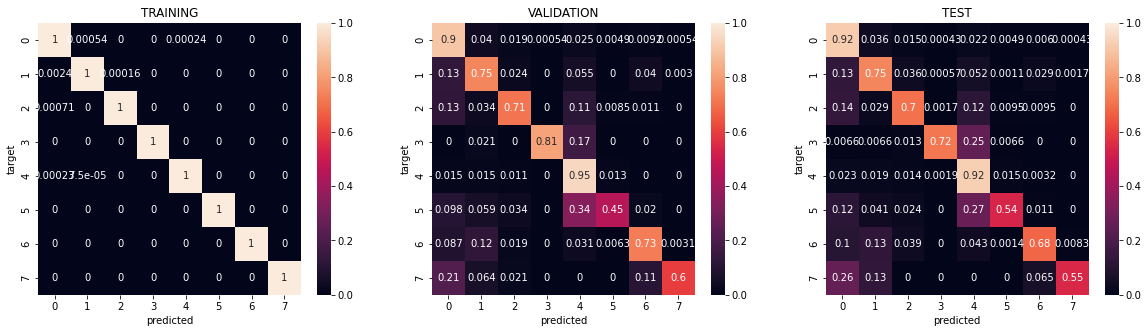

In [25]:
# 17 HeatMap Görselleştirmesi..
plt.figure(figsize = (20,5))

for i, (label, cm) in enumerate(zip(["TRAINING", "VALIDATION", "TEST"], [train_cm, val_cm, test_cm])):
    plt.subplot(131+i)

    df_cm = pd.DataFrame(cm, index=range(8), columns=range(8))

    plt.title(label)
    ax = sn.heatmap(df_cm, annot=True, vmin=0, vmax=1)
    ax.set(xlabel='predicted', ylabel='target')

Yukarıdaki karışıklık matrisleri, LightGBM'nin eğitim verilerine neredeyse mükemmel şekilde uyabildiğini göstermektedir. Ancak doğrulama ve test verisi alt kümelerinde modelin öngörülebilirliği daha düşüktür. Özellikle, model sınıf 0 - Cirrus'ta iyi performans gösterirken, sınıf 7 - Derin Konveksiyon karoları genellikle sınıf 0 - Cirrus veya 1 - Altostratus olarak yanlış sınıflandırılır.

Ayrıca, Makine Öğrenimi sınıflandırıcılarının kalitesini değerlendirmek için standart olan iki metriği kullanarak modelin performansını değerlendirebilirsiniz:
* **accuracy :** Doğru sınıflandırılmış verilerin genel oranı
* **average F1 score :** Her bulut türü için model kesinliğini (gerçek pozitiflerin tüm pozitiflere oranı) ve geri çağırmayı (gerçek pozitiflerin o sınıfın tüm kutucuklarına oranı) hesaba katan bir metrik. F1 Skoru [0, 1] arasında değişebilir ve bu 1, mükemmel kesinlik ve hatırlamayı gösterir. Bu nedenle, F1 puanı ne kadar yüksek olursa o kadar iyidir.

In [26]:
# 18 Modelin Değerlendirmesi

accuracy = accuracy_score(test_ys, test_y_pred)
f1 = f1_score(test_ys, test_y_pred, average='macro')

print("Test accuracy:", accuracy)
print("Test f1 score:", f1)

Test accuracy: 0.8420517632340292
Test f1 score: 0.7633565206406072
